# 5. XGBoost on BNB/USDT 1m Returns

This notebook trains an XGBoost regressor to predict one‐step log‐returns of BNB/USDT. It includes feature engineering, GPU/MPS support, training loops with progress bars, and evaluation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import torch

# Device detection for GPU/MPS (not used by XGBoost but kept for consistency)
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Device:", device)

Device: mps


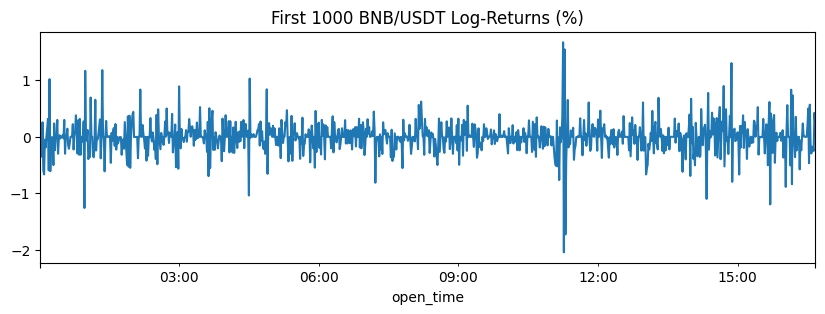

In [3]:
# Load data
df = pd.read_csv(
    '/Users/mchildress/Active Code/ts_basics/data/bnbusdt_1m.csv',
    parse_dates=['open_time'], index_col='open_time'
)
# Compute log‐returns and drop NaNs
df['log_ret'] = np.log(df['close']).diff() * 100
df = df.dropna(subset=['log_ret'])
plt.figure(figsize=(10,3))
df['log_ret'].iloc[:1000].plot(title='First 1000 BNB/USDT Log‐Returns (%)')
plt.show()

In [4]:
# Feature engineering
SEQ_LEN = 60
df['lag1'] = df['log_ret'].shift(1)
df['roll5'] = df['log_ret'].rolling(5).mean()
df['roll10']= df['log_ret'].rolling(10).std()
df_feat = df[['log_ret','lag1','roll5','roll10']].dropna()

# Build X, y for one‐step prediction
X, Y = [], []
arr = df_feat.values.astype(np.float32)
for i in range(len(arr)-SEQ_LEN):
    X.append(arr[i:i+SEQ_LEN])
    Y.append(arr[i+SEQ_LEN,0])
X, Y = np.stack(X), np.stack(Y)

# train/test split
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

In [5]:
# Flatten sequence dimension for XGBoost
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

dtrain = xgb.DMatrix(X_train_flat, label=Y_train)
dtest  = xgb.DMatrix(X_test_flat,  label=Y_test)

params = {
    "objective": "reg:squarederror",
    "tree_method": "gpu_hist"
}

In [7]:
num_round = 200
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

from xgboost.callback import TrainingCallback

class TqdmCallback(TrainingCallback):
    def __init__(self, pbar):
        self.pbar = pbar

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False

with tqdm(total=num_round, desc="Boosting rounds") as pbar:
    model = xgb.train(
        params, dtrain,
        num_boost_round=num_round,
        evals=watchlist,
        verbose_eval=False,
        callbacks=[TqdmCallback(pbar)]
    )

Boosting rounds:   0%|          | 0/200 [00:00<?, ?it/s]


XGBoostError: [18:01:41] /Users/runner/work/xgboost/xgboost/src/gbm/../common/common.h:168: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000030868dbfc dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000308870460 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 1280
  [bt] (2) 3   libxgboost.dylib                    0x000000030888fefc xgboost::LearnerConfiguration::Configure() + 1272
  [bt] (3) 4   libxgboost.dylib                    0x000000030889014c xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000003086b0788 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.dylib                        0x00000001a6c15050 ffi_call_SYSV + 80
  [bt] (6) 7   libffi.dylib                        0x00000001a6c1daf0 ffi_call_int + 1220
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000110972444 _ctypes_callproc + 1308
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000011096ac74 PyCFuncPtr_call + 1240



In [ ]:
# Predictions & RMSE
preds = model.predict(dtest)
rmse = mean_squared_error(Y_test, preds, squared=False)
print(f"Test RMSE: {rmse:.3f}")

plt.figure(figsize=(10,4))
plt.plot(Y_test[:200], label='True')
plt.plot(preds[:200], label='Pred', alpha=0.7)
plt.legend()
plt.title('XGBoost One‐Step Return Prediction (first 200 points)')
plt.show()